In [1]:
import numpy as np
import pandas as pd
import os
from gensim.models import Word2Vec
from generate_sentence import sentence_generator
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
import itertools
import random


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.manifold import TSNE

data_root = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Processed/Yufeng/Original_data'
raw_data_root = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Processed/NSF HF Dataset/'
cohort_1_root = os.path.join(data_root,'cohort_1')
cohort_23_root = os.path.join(data_root,'cohort_23')
assign_file = os.path.join(raw_data_root,'Original/Cohort Assignment.csv')
file_code_name = ['VAclass','PCT','ICD']

## generate sentence

In [2]:
def train_word2vec(document,vector_size,sg = 1):
    model = Word2Vec(sentences = document, vector_size = vector_size, window = 5, min_count = 1, workers = 4,sg = sg)
    word_embed_dict = dict({})
    for idx, key in enumerate(model.wv.key_to_index):
        word_embed_dict[key] = model.wv[key]
    return word_embed_dict



def split_data(data,test_size = 0.3,random_state = 1234):
    train_data,test_data = train_test_split(data,test_size = test_size,random_state = random_state)
    return train_data,test_data

def shuffle_doc(code_doc,seed):
    random.seed(seed)
    code_s = [random.sample(line, len(line)) for line in code_doc]
    return code_s

sentence_gen = sentence_generator(cohort_1_root,cohort_23_root,assign_file)
cohort,VA,CPT,ICD = sentence_gen.process_two_cohorts_with_no_label_mapping()
code_doc = cohort.full_code.tolist()
###############################################################
print(' There are {} records '.format(cohort.shape[0]))
print(' The number of VA code is {} and the number of CPT code is {} and the number of ICD code is {}'.format(len(np.unique(VA)),len(np.unique(CPT)),len(np.unique(ICD))))
print(" Total number of codes is {}".format(len(np.unique(VA))+len(np.unique(CPT))+len(np.unique(ICD))))
###############################################################
phecode = pd.read_csv('../data_temp/Phecode_map_v1_2_icd10cm_beta.csv',encoding = "ISO-8859-1")
HF_codes = list(phecode[phecode['phecode_str'].str.contains("Heart failure")]['icd10cm'])

cohort 1 and 23 merged (7049, 7)
The average length of medical sentences: 1338
 There are 7049 records 
 The number of VA code is 239 and the number of CPT code is 2229 and the number of ICD code is 5970
 Total number of codes is 8438


## Word2vec

In [3]:
code_embed_dict = train_word2vec(code_doc,vector_size = 100,sg = 1)
embedding = np.stack(list(code_embed_dict.values()),axis = 0)
embedding_names = np.array(list(code_embed_dict.keys()))

In [76]:
d_root = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Processed/Yufeng/'
phecode_map = pd.read_csv(os.path.join(d_root,'Phecode_map_v1_2_icd10cm_beta.csv'),encoding = "ISO-8859-1")
HF_codes = list(phecode_map[phecode_map['phecode_str'].str.contains("Heart failure")]['icd10cm'])

## Visulization

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
print(sns.__version__)
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

0.11.0


In [5]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding)

/home/chloezh/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/chloezh/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8438 samples in 0.001s...
[t-SNE] Computed neighbors for 8438 samples in 2.470s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8438
[t-SNE] Computed conditional probabilities for sample 2000 / 8438
[t-SNE] Computed conditional probabilities for sample 3000 / 8438
[t-SNE] Computed conditional probabilities for sample 4000 / 8438
[t-SNE] Computed conditional probabilities for sample 5000 / 8438
[t-SNE] Computed conditional probabilities for sample 6000 / 8438
[t-SNE] Computed conditional probabilities for sample 7000 / 8438
[t-SNE] Computed conditional probabilities for sample 8000 / 8438
[t-SNE] Computed conditional probabilities for sample 8438 / 8438
[t-SNE] Mean sigma: 0.127983
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.706940
[t-SNE] KL divergence after 300 iterations: 2.581875


In [6]:
embedding_group_dict = dict.fromkeys(embedding_names, None)
for name in embedding_names:
    if name in VA:
        embedding_group_dict[name] = 'VAclass'
    elif name in CPT:
        embedding_group_dict[name]= 'CPT-4'
    elif name in ICD:
        if name in HF_codes:
            embedding_group_dict[name]= 'Heart Failure'       
        else:
            embedding_group_dict[name]= 'ICD-10'

In [7]:
df = pd.DataFrame(tsne_results,columns = ['one','two'])
df['names'] = embedding_names
df['group'] = df['names'].apply(lambda x: embedding_group_dict[x])

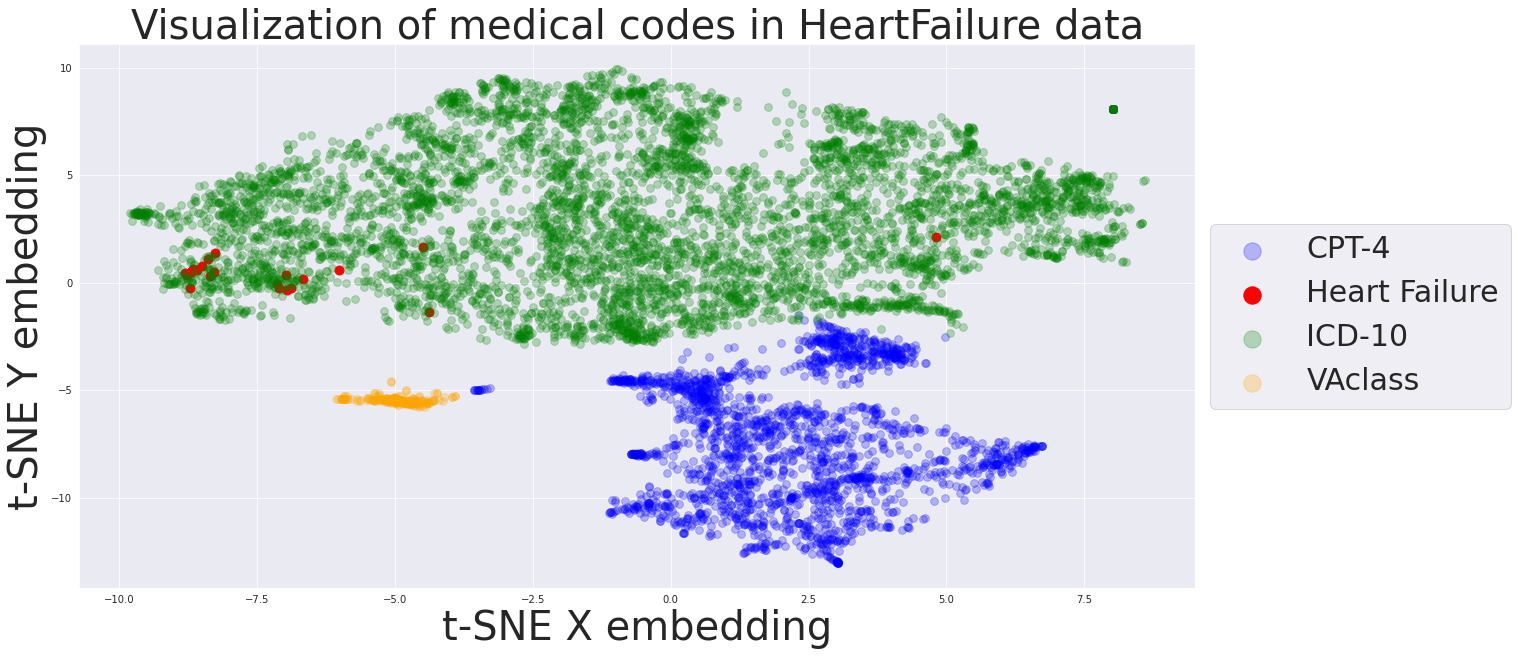

In [14]:
sns.set_style("darkgrid", {'axes.grid' : True})
scatter_x = np.array(df['one'])
scatter_y = np.array(df['two'])
group = np.array(df['group'])
group_color = {'Heart Failure':'red',
                'ICD-10':'green',
                'CPT-4':'blue',
                'VAclass':'orange',}

fig, ax = plt.subplots(figsize=(20,10))
for g in np.unique(group):
    ix = np.where(group == g)
    if g == 'ICD-10' or g == 'CPT-4' or g == 'VAclass':
        alpha = 0.25
        s = 60
    else:
        alpha = 1.0
        s = 80
    ax.scatter(scatter_x[ix], scatter_y[ix], c = group_color[g], label = g, s = s,alpha = alpha)
lgnd = ax.legend(fontsize=30,scatterpoints=1,loc='center left', bbox_to_anchor=(1, 0.5))
for handle in lgnd.legendHandles:
    handle.set_sizes([300.0])

plt.title('Visualization of medical codes in HeartFailure data',fontsize= 40)
plt.xlabel('t-SNE X embedding',fontsize= 40)
plt.ylabel('t-SNE Y embedding',fontsize= 40)
plt.show()

In [15]:
group_disease = {'J':'Diseases of the respiratory system',
                'K':'Diseases of the digestive system',
                'I':'Diseases of the circulatory system',
                'G':'Diseases of the nervous system',
                'D':'Diseases of the blood and blood-forming organs',
                'E':'Endocrine, nutritional and metabolic diseases',
                'M':'Diseases of the musculoskeletal system and connective tissue',
                'N':'Diseases of the genitourinary system'
                }

In [17]:
group_color = {'J':'red',
                'K':'blue',
                'I':'green',
                'G':'orange',
                'D':'purple',
                'E':'brown',
                'M':'pink',
                'N':'grey'
              }

In [18]:
embedding_group_dict = dict.fromkeys(embedding_names, None)
for name in embedding_names:
    if name in ICD:
        s = name[0]
        if s in group_disease.keys():
              embedding_group_dict[name]=name[0].upper()
        else:
            embedding_group_dict[name]= 'Other ICD codes'
    else:
        embedding_group_dict[name]= 'Unknown'

In [19]:
df = pd.DataFrame(tsne_results,columns = ['one','two'])
df['names'] = embedding_names
df['group'] = df['names'].apply(lambda x: embedding_group_dict[x])

In [20]:
df_ICD = df[df['group'] != 'Unknown']
df_ICD = df_ICD[df_ICD['group'] != 'Other ICD codes']

In [21]:
df_ICD['color'] = df_ICD['group'].apply(lambda x: group_color[x])
df_ICD['system'] = df_ICD['group'].apply(lambda x: group_disease[x])

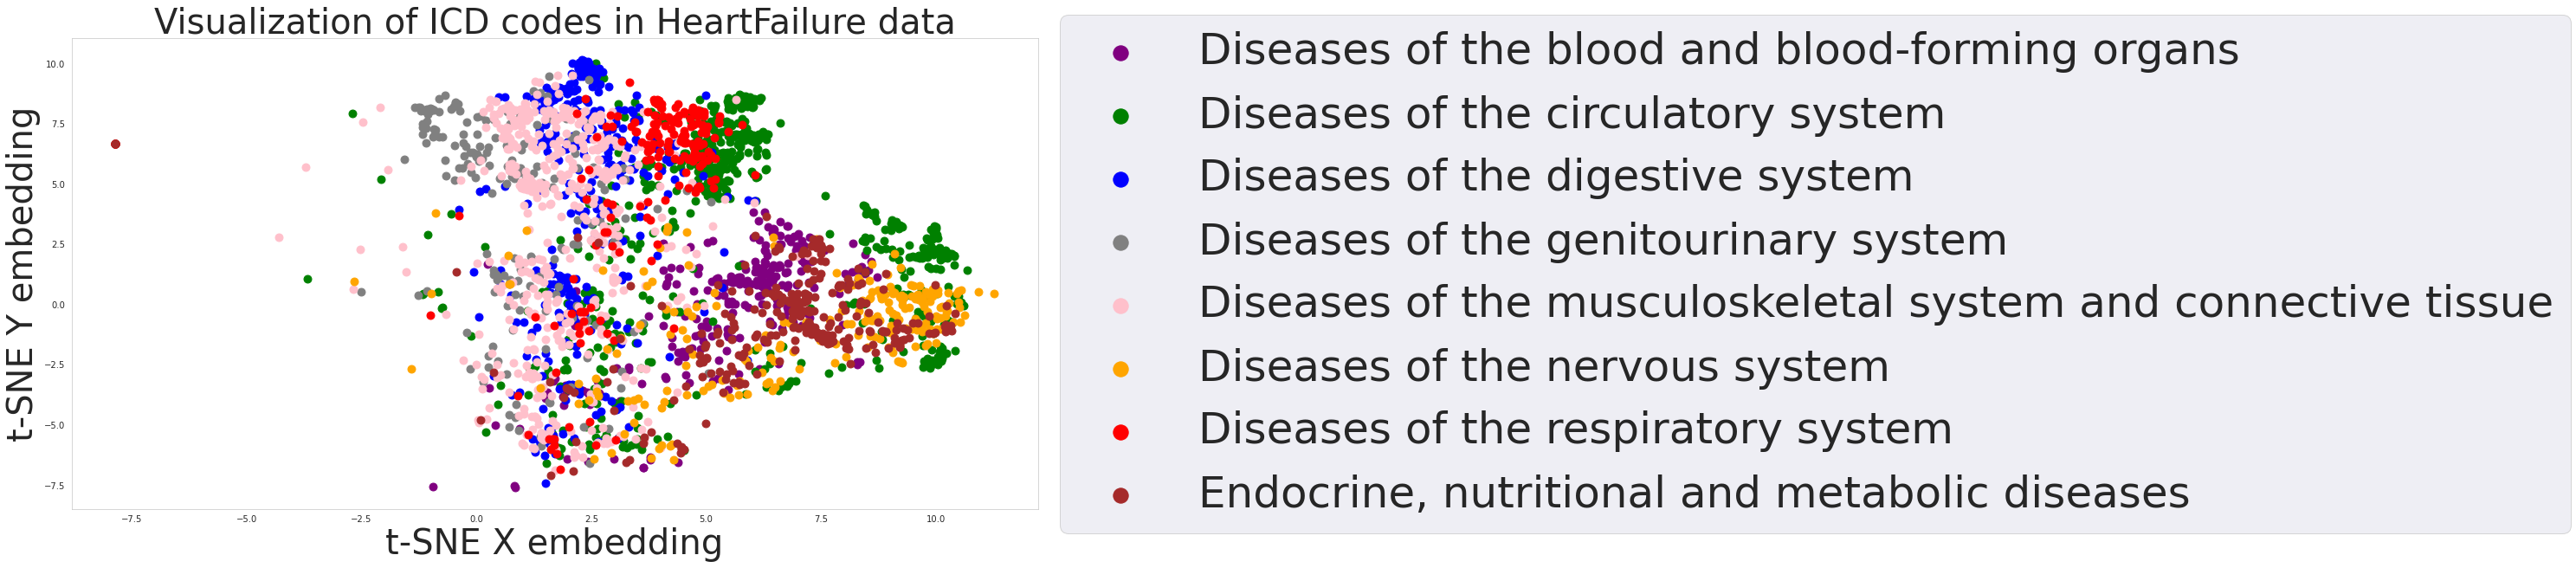

In [99]:
scatter_x = np.array(df_ICD['one'])
scatter_y = np.array(df_ICD['two'])
group = np.array(df_ICD['system'])
group_color = {'Diseases of the respiratory system':'red',
                'Diseases of the digestive system':'blue',
                'Diseases of the circulatory system':'green',
                'Diseases of the nervous system':'orange',
                'Diseases of the blood and blood-forming organs':'purple',
                'Endocrine, nutritional and metabolic diseases':'brown',
                'Diseases of the musculoskeletal system and connective tissue':'pink',
                'Diseases of the genitourinary system':'grey'
              }

fig, ax = plt.subplots(figsize=(20,10))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = group_color[g], label = g, s = 80)
# ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5),borderpad=3, labelspacing=1.5)
lgnd = ax.legend(fontsize=50,scatterpoints=1,loc='center left', bbox_to_anchor=(1, 0.5))
for handle in lgnd.legendHandles:
    handle.set_sizes([300.0])
plt.title('Visualization of ICD codes in HeartFailure data',fontsize= 40)
plt.xlabel('t-SNE X embedding',fontsize= 40)
plt.ylabel('t-SNE Y embedding',fontsize= 40)
plt.show()
# plt.savefig('../plot/ICD_embeddings.png', bbox_inches='tight')

In [94]:
# fig, ax = plt.subplots(figsize=(20,10))
# ax.scatter(x = df_ICD['one'], y = df_ICD['two'],c=df_ICD['color'],
#                alpha=1.0, edgecolors='none')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [64]:
# plt.figure(figsize=(20,10))
# p1 = sns.scatterplot(data = df,
#                        x = 'one',
#                        y = 'two',
#                        sizes=(8, 8),
#                        alpha = 0.7,
#                        hue = 'group')

# l1 = p1.legend(fancybox = True, framealpha = 1, shadow = True, borderpad = 1,loc='upper left',fontsize= 15)
# plt.title('Visualization of Embeddings for medical codes in HeartFailure data - 2D tsne',fontsize= 30)
# plt.xlabel('X coordinates',fontsize= 30)
# plt.ylabel('Y coordinates',fontsize= 30)



# def label_point(tsne_results, ax):
#     for i, point in df.iterrows():
# #          if point['names'].startswith( 'I50') and point['names'] != 'I50.83' and point['names'] != 'I50.89':
# #                 print('The index in {} and the code is {}'.format(i,point['names']))
#                 ax.text(x = point['one'], y = point['two'], s = str(point['names']),size = 20,alpha = 1.0)
#                 ax.scatter(point['one'], point['two'], marker='o',color = 'black',s = 40,alpha = 0.5)
# label_point(df,p1)
# fig = p1.get_figure()
# fig.savefig('./plot/sgns_embedding_2d_shuffle.png')

In [ ]:
len(embedding_names)

In [ ]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding)
df = pd.DataFrame(tsne_results,columns = ['one','two','three'])
df['names'] = embedding_names
df['group'] = df['names'].apply(lambda x: embedding_group_dict[x])

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.gca(projection='3d')
for grp_name, grp_idx in df.groupby('group').groups.items():
    y = df.iloc[grp_idx,1]
    x = df.iloc[grp_idx,0]
    z = df.iloc[grp_idx,2]
    ax.scatter(x,y,z, label=grp_name,marker='o',s = 12,alpha = 0.6) 
ax.legend(fancybox = True, framealpha = 1, shadow = True, borderpad = 1,loc='upper left',fontsize=10)
ax.set_xlabel('X coordinates', fontsize=10)
ax.set_ylabel('Y coordinates', fontsize=10)
ax.set_title('Visualization of Embeddings for medical codes in HeartFailure data - 3D tsne', fontsize=20)
def label_point(tsne_results, ax):
    for i, point in df.iterrows():
        if point['names'].startswith( 'I50' ):
#             print('The index in {} and the code is {}'.format(i,point['names']))
            ax.text(x = point['one'], y = point['two'], z = point['three'],s = str(point['names']),size = 20,alpha = 0.8)
            ax.scatter(point['one'], point['two'], point['three'],marker='o',color = 'black',s = 20,alpha = 0.9)
label_point(df,ax)
fig = ax.get_figure()
fig.savefig('./plot/embedding_3d_shuffle.pdf')

In [ ]:
import sklearn

In [ ]:
embed_dist = sklearn.metrics.pairwise.cosine_similarity(embedding,embedding)

In [ ]:
embed_dist_df = pd.DataFrame(embed_dist,columns = embedding_names,index =embedding_names) 

In [ ]:
embed_dist_df.head()

In [ ]:
phecode_sim = pd.read_csv('./embeddings/sgns_phecode_sub_similarity.csv')

In [ ]:
phecode_sim = phecode_sim.iloc[:,0].to_numpy()

In [ ]:
np.sum(phecode_sim == 1) / len(phecode_sim)

In [ ]:
cosine_sim = pd.read_csv("./embeddings/sgns_cosine_similarity.csv")

In [ ]:
cosine_sim = cosine_sim.iloc[:,0].to_numpy()

In [ ]:
np.sum(cosine_sim > 0.5) / len(cosine_sim)

In [ ]:
phe_index = np. asarray(np.where(phecode_sim == 1))
cos_index = np. asarray(np.where(cosine_sim > 0.5))

In [ ]:
index_intersect = np.intersect1d(phe_index,cos_index)

In [ ]:
len(index_intersect)

In [ ]:
cos_index.shape

In [ ]:
phe_index.shape

In [ ]:
cosine_sim.shape

In [ ]:
5902718/32644081

In [ ]:
from numpy import genfromtxt
embedding = genfromtxt('./embeddings/embedding.csv', delimiter=',')

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding)

In [ ]:
df = pd.DataFrame(tsne_results,columns = ['one','two'])

In [ ]:
import csv

row_names = []
with open("./embeddings/embedding_row_names.csv", "r") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        row_names.extend(line)

In [ ]:
embedding_group_dict[''] = 'Outlier'
embedding_group_dict["'J43.9'"] = 'Outlier'
embedding_group_dict["S03.0xxS'"] = 'Outlier'

In [ ]:
df['names'] = row_names
df['group'] = df['names'].apply(lambda x: embedding_group_dict[x])

In [ ]:
10000000000/187

In [ ]:
from numpy import genfromtxt
cosine_similarity = pd.read_csv('./embeddings/true_sgns_cosine_similarity.csv')

In [ ]:
phecode_similarity = pd.read_csv('./embeddings/sgns_phecode_sub_similarity.csv')

In [ ]:
x = phecode_similarity.to_numpy()

In [ ]:
positive_idx = np.where(x == 1)

In [ ]:
sample_size = sum(x == 1)

In [ ]:
negative_idx = np.where(x == 0)

In [ ]:
sampled_negative_idx = np.random.choice(negative_idx[0], size=sample_size, replace=False)

In [ ]:
positive_idx[0].shape

In [ ]:
select_idx = np.concatenate([positive_idx[0],sampled_negative_idx],axis = 0)
select_idx.shape

In [ ]:
x[select_idx,:].reshape((1,-1))[0]

In [ ]:
selecgt_cos = cosine_similarity.iloc[select_idx,:].to_numpy().reshape((1,-1))[0]

In [ ]:
selecgt_cos_pred = [ 1 if pair > 0.8 else 0 for pair in selecgt_cos]

In [ ]:
selecgt_phe = phecode_similarity.iloc[select_idx,:].to_numpy().reshape((1,-1))[0]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(selecgt_phe+1, selecgt_cos, pos_label=2)
auc = metrics.auc(fpr, tpr)
print(auc)


In [ ]:
recall = sklearn.metrics.recall_score(selecgt_phe, selecgt_cos_pred, average='binary')
        
# precision
precision = sklearn.metrics.precision_score(selecgt_phe, selecgt_cos_pred, average='binary', zero_division=0)

# specificity
specificity = sklearn.metrics.recall_score(1-selecgt_phe, 1-np.array(selecgt_cos_pred), average='binary')

In [ ]:
recall

In [ ]:
precision

In [ ]:
specificity

In [ ]:
f1 = 2*precision*recall/(precision + recall + 0.1)

In [ ]:
f1

In [ ]:
len(negative_idx[0])/len(positive_idx[0])

In [ ]:
def imbalanced_metrics(cos,phe):
    positive_idx = np.where(phe == 1)
    negative_idx = np.where(x == 0)
    sample_size = sum(phe == 1)
    
    seeds = np.arange(10)
    
    
    acc_ls = []
    auc_ls = []
    precision_ls = []
    spec_ls = []
    recall_ls = []
    f1_ls = []
    
    for seed in seeds:
        np.random.seed(seed)


        sampled_negative_idx = np.random.choice(negative_idx[0], size=sample_size, replace=False)

        select_idx = np.concatenate([positive_idx[0],sampled_negative_idx],axis = 0)

        select_cos = cos[select_idx]
        select_phe = phe[select_idx]
        select_cos_pred = [ 1 if pair > 0.8 else 0 for pair in select_cos]

        # acc
        # auc
        fpr, tpr, thresholds = metrics.roc_curve(select_phe+1, select_cos, pos_label=2)
        auc = metrics.auc(fpr, tpr)
        #recall
        recall = sklearn.metrics.recall_score(select_phe, select_cos_pred, average='binary')
        # precision
        precision = sklearn.metrics.precision_score(select_phe, select_cos_pred, average='binary', zero_division=0)
        # specificity
        specificity = sklearn.metrics.recall_score(1-select_phe, 1-np.array(select_cos_pred), average='binary')
        # f1
        f1 = 2*precision*recall/(precision + recall + 0.1)
        # acc
        acc = np.sum(select_phe == select_cos_pred)/len(select_cos)
        
        
        acc_ls.append(acc)
        auc_ls.append(auc)
        precision_ls.append(precision)
        spec_ls.append(specificity)
        recall_ls.append(recall)
        f1_ls.append(f1)
        
    return acc_ls,auc_ls,precision_ls,spec_ls,recall_ls,f1_ls


In [ ]:
phe = phecode_similarity.to_numpy().reshape((1,-1))[0]

In [ ]:
cos = cosine_similarity.to_numpy().reshape((1,-1))[0]

In [ ]:
acc_ls,auc_ls,precision_ls,spec_ls,recall_ls,f1_ls = imbalanced_metrics(cos,phe)

In [ ]:
np.mean(acc_ls)

In [ ]:
np.mean(auc_ls)

In [ ]:
np.mean(precision_ls)

In [ ]:
print(np.mean(spec_ls))
print(np.mean(recall_ls))
print(np.mean(f1_ls))

In [125]:
## AUC varies dimenmsions

In [129]:
SGNS = [0.73,0.72,0.72,0.72,0.71]
CBOW = [0.65,0.65,0.65,0.65,0.65]
dims = [60,80,100,150,200]

In [130]:
embed_auc = {'SGNS':SGNS,'CBOW':CBOW,'dim':dims}

In [131]:
embed_auc_df = pd.DataFrame.from_dict(embed_auc)

In [132]:
embed_auc_df

,SGNS,CBOW,dim
0,0.73,0.65,60
1,0.72,0.65,80
2,0.72,0.65,100
3,0.72,0.65,150
4,0.71,0.65,200


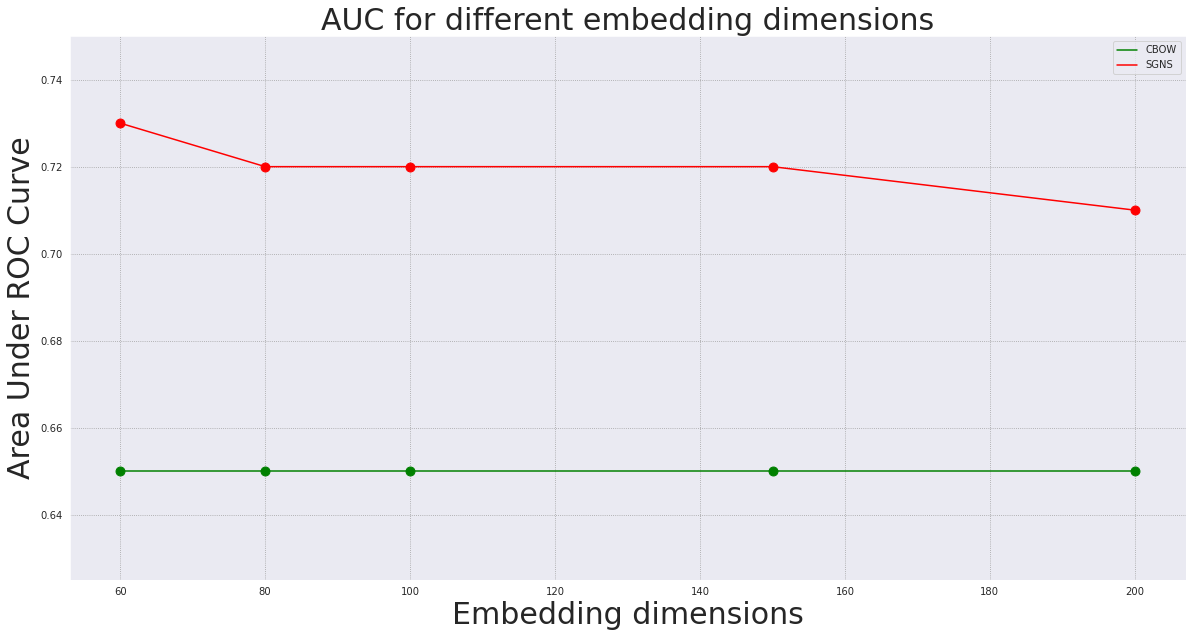

In [144]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(dims, CBOW, 'g', label='CBOW')
plt.plot(dims, SGNS, 'r', label='SGNS')
plt.scatter(dims, CBOW, c = 'g',s = 80)
plt.scatter(dims, SGNS, c = 'r',s = 80)
plt.title('AUC for different embedding dimensions',fontsize= 30)
plt.ylabel('Area Under ROC Curve',fontsize= 30)
plt.xlabel('Embedding dimensions',fontsize= 30)
plt.grid(True)
plt.ylim((0.625,0.75))
plt.legend()
# plt.show()
fig.savefig('../plot/embedding_dimension.png')